In [1]:
#####################################################
# Script to create grids of warning data to use for
# training and verification
##################################################### 

#==============
# Imports 
#==============
from shapely.geometry import Point
import pandas as pd
import datetime as dt
from wofs_phi import Grid
import utilities
import numpy as np
import config as c
import geopandas as gpd
from wofs_phi import MLTrainer

ImportError: attempted relative import with no known parent package

In [56]:
class Warning_GDF():
    def __init__(self, year):
        self.year = year
        
    def convert_dates_to_real(self):
    
        self.formatted_gdf = self.raw_gdf.drop(columns = ['ISSUED', 'EXPIRED'])

        self.formatted_gdf = self.formatted_gdf.assign(ISSUED_YEAR=0)
        self.formatted_gdf = self.formatted_gdf.assign(ISSUED_MONTH=0)
        self.formatted_gdf = self.formatted_gdf.assign(ISSUED_DAY=0)
        self.formatted_gdf = self.formatted_gdf.assign(ISSUED_HOUR=0)
        self.formatted_gdf = self.formatted_gdf.assign(ISSUED_MINUTE=0)

        self.formatted_gdf = self.formatted_gdf.assign(EXPIRED_YEAR=0)
        self.formatted_gdf = self.formatted_gdf.assign(EXPIRED_MONTH=0)
        self.formatted_gdf = self.formatted_gdf.assign(EXPIRED_DAY=0)
        self.formatted_gdf = self.formatted_gdf.assign(EXPIRED_HOUR=0)
        self.formatted_gdf = self.formatted_gdf.assign(EXPIRED_MINUTE=0)

        self.formatted_gdf = self.formatted_gdf.assign(ISSUED_SUM = 0)
        self.formatted_gdf = self.formatted_gdf.assign(EXPIRED_SUM = 0)

        for i in range(len(self.raw_gdf.ISSUED)):
            days = self.raw_gdf.ISSUED.iat[i].split('-')
            issued_year = int(days[0])
            issued_month = int(days[1])
            time = days[2]
            issued_day = int(time.split(' ')[0])
            hourMin = time.split(' ')[1]
            issued_hour = int(hourMin.split(':')[0])
            issued_minute = int(hourMin.split(':')[1])
            issued_time = dt.datetime(issued_year, issued_month, issued_day, issued_hour, issued_minute)
            if issued_time.hour < c.wofs_reset_hour:
                issued_time -= dt.timedelta(days = 1)
                issued_hour += 24

            days = self.raw_gdf.EXPIRED.iat[i].split('-')
            expired_year = int(days[0])
            expired_month = int(days[1])
            time = days[2]
            expired_day = int(time.split(' ')[0])
            hourMin = time.split(' ')[1]
            expired_hour = int(hourMin.split(':')[0])
            expired_minute = int(hourMin.split(':')[1])
            expired_time = dt.datetime(expired_year, expired_month, expired_day, expired_hour, expired_minute)
            if expired_time.hour < c.wofs_reset_hour:
                expired_time -= dt.timedelta(days = 1)
                expired_hour += 24
            
            self.formatted_gdf.ISSUED_YEAR.iat[i] = issued_time.year
            self.formatted_gdf.ISSUED_MONTH.iat[i] = issued_time.month
            self.formatted_gdf.ISSUED_DAY.iat[i] = issued_time.day
            self.formatted_gdf.ISSUED_HOUR.iat[i] = issued_time.hour
            self.formatted_gdf.ISSUED_MINUTE.iat[i] = issued_time.minute

            self.formatted_gdf.EXPIRED_YEAR.iat[i] = expired_time.year
            self.formatted_gdf.EXPIRED_MONTH.iat[i] = expired_time.month
            self.formatted_gdf.EXPIRED_DAY.iat[i] = expired_time.day
            self.formatted_gdf.EXPIRED_HOUR.iat[i] = expired_time.hour
            self.formatted_gdf.EXPIRED_MINUTE.iat[i] = expired_time.minute

            if issued_hour <= 9:
                issued_hour_str = Warning_GDF.add_str_0(issued_hour)
            else:
                issued_hour_str = str(issued_hour)
            if issued_minute <= 9:
                issued_min_str = Warning_GDF.add_str_0(issued_minute)
            else:
                issued_min_str = str(issued_minute)
            if expired_hour <= 9:
                expired_hour_str = Warning_GDF.add_str_0(expired_hour)
            else:
                expired_hour_str = str(expired_hour)
            if expired_minute <= 9:
                expired_min_str = Warning_GDF.add_str_0(expired_minute)
            else:
                expired_min_str = str(expired_minute)

            self.formatted_gdf.ISSUED_SUM.iat[i] = issued_hour_str + issued_min_str
            self.formatted_gdf.EXPIRED_SUM.iat[i] = expired_hour_str + expired_min_str
    
    def set_raw_gdf(self):
        data = pd.read_csv(self.csv)
        shape_data = gpd.read_file(self.shapes)

        severe_indices = data['PHENOM'] == "SV"
        torn_indices = data['PHENOM'] == 'TO'
        combined_indices = severe_indices | torn_indices

        combined_data = data[combined_indices] #Only select the tornado-warned examples
        combined_shape = shape_data[combined_indices] #Select the corresponding examples (set of points) from the shapefile

        combined_gdf = gpd.GeoDataFrame(combined_data, geometry = combined_shape['geometry'])

        simplified_gdf = combined_gdf.drop(columns=['WFO', 'INIT_ISS', 'INIT_EXP', 'PHENOM', 'GTYPE', 'SIG', 'ETN', 'STATUS',
                                             'HVTEC_CAUSE', 'HVTEC_RECORD', 'IS_EMERGENCY', 'POLYBEGIN', 'POLYEND',
                                               'WINDTAG', 'HAILTAG', 'TORNADOTAG', 'DAMAGETAG', 'NWS_UGC', 'AREA_KM2',
                                               'UPDATED', 'HVTEC_NWSLI', 'HVTEC_SEVERITY'])

        simplified_gdf = simplified_gdf.assign(TORN_MAP=0)
        simplified_gdf = simplified_gdf.assign(WIND_MAP=0)
        simplified_gdf = simplified_gdf.assign(HAIL_MAP=0)
        simplified_gdf = simplified_gdf.assign(SIG_MAP=0)
        simplified_gdf = simplified_gdf.assign(SIG_SEVERE_MAP=0)
        simplified_gdf = simplified_gdf.assign(SIG_TORN_MAP=0)
        simplified_gdf = simplified_gdf.assign(SEVERE_MAP=0)
        simplified_gdf = simplified_gdf.assign(ALL_HAZ_MAP=0)

        for i in range(len(simplified_gdf.WIND_MAP)):
            if combined_gdf.TORNADOTAG.iat[i] == 'RADAR INDICATED' or combined_gdf.TORNADOTAG.iat[i] == 'OBSERVED':
                simplified_gdf.TORN_MAP.iat[i] = 1
                simplified_gdf.ALL_HAZ_MAP.iat[i] = 1
                if (combined_gdf.DAMAGETAG.iat[i] == 'CONSIDERABLE') or (combined_gdf.DAMAGETAG.iat[i] == 'CATASTROPHIC') or (combined_gdf.DAMAGETAG.iat[i] == 'DESTRUCTIVE'):
                    simplified_gdf.SIG_MAP.iat[i] = 1
                    simplified_gdf.SIG_TORN_MAP.iat[i] = 1
            elif combined_gdf.TORNADOTAG.iat[i] == 'POSSIBLE':
                simplified_gdf.TORN_MAP.iat[i] = 1
                simplified_gdf.ALL_HAZ_MAP.iat[i] = 1
                if (combined_gdf.DAMAGETAG.iat[i] == 'CONSIDERABLE') or (combined_gdf.DAMAGETAG.iat[i] == 'CATASTROPHIC') or (combined_gdf.DAMAGETAG.iat[i] == 'DESTRUCTIVE'):
                    simplified_gdf.SIG_MAP.iat[i] = 1
            if not combined_gdf.WINDTAG.iat[i] == 'None':
                if float(combined_gdf.WINDTAG.iat[i]) >= 60:
                    simplified_gdf.WIND_MAP.iat[i] = 1
                    simplified_gdf.SEVERE_MAP.iat[i] = 1
                    simplified_gdf.ALL_HAZ_MAP.iat[i] = 1
                if (float(combined_gdf.WINDTAG.iat[i]) >= 70) or (combined_gdf.DAMAGETAG.iat[i] == 'CONSIDERABLE') or (combined_gdf.DAMAGETAG.iat[i] == 'CATASTROPHIC') or (combined_gdf.DAMAGETAG.iat[i] == 'DESTRUCTIVE'):
                    simplified_gdf.SIG_MAP.iat[i] = 1
                    simplified_gdf.SIG_SEVERE_MAP.iat[i] = 1
            if not combined_gdf.HAILTAG.iat[i] == 'None':
                if float(combined_gdf.HAILTAG.iat[i]) >= 1:
                    simplified_gdf.HAIL_MAP.iat[i] = 1
                    simplified_gdf.SEVERE_MAP.iat[i] = 1
                    simplified_gdf.ALL_HAZ_MAP.iat[i] = 1
                if (float(combined_gdf.HAILTAG.iat[i]) >= 1.75) or (combined_gdf.DAMAGETAG.iat[i] == 'CONSIDERABLE') or (combined_gdf.DAMAGETAG.iat[i] == 'CATASTROPHIC') or (combined_gdf.DAMAGETAG.iat[i] == 'DESTRUCTIVE'):
                    simplified_gdf.SIG_MAP.iat[i] = 1
                    simplified_gdf.SIG_SEVERE_MAP.iat[i] = 1
                

        self.raw_gdf = simplified_gdf
    
    def set_formatted_gdf(self):
        self.csv = '%s/wwa_%s01010000_%s12312359.csv' %(c.train_warnings_csv_dir, self.year, self.year)
        self.shapes = '%s/wwa_%s01010000_%s12312359.shp' %(c.train_warnings_csv_dir, self.year, self.year)
        self.set_raw_gdf()
        self.convert_dates_to_real()
    
    def save_gdf(self):
        self.formatted_gdf.to_csv('%s/warnings_%s.csv' %(c.train_warnings_csv_dir, self.year))
    
    def load_warnings(year):
        filename = '%s/warnings_%s.csv' %(c.train_warnings_csv_dir, year)
        return (gpd.read_file(filename, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")).drop(columns = ['field_1'])
    
    @staticmethod
    def add_str_0(num):
        return str(0) + str(num)

In [75]:
class Warning_Grid():
    
    SAMPLE_WOFS_INIT_TIME = '2200'
    
    def __init__(self, haz, start, length):
        self.haz = haz
        self.start_time = start
        self.length = length
        self.end_time = self.start_time + dt.timedelta(seconds = length*60)
        
        start_date_str = dt.datetime.strftime(self.start_time, '%Y%m%d')
        wofs_path = '%s/%s/%s' %(c.wofs_base_path, start_date_str, Warning_Grid.SAMPLE_WOFS_INIT_TIME)
        wofs_file = 'wofs_SWT_00_%s_%s_%s.nc' %(start_date_str, Warning_Grid.SAMPLE_WOFS_INIT_TIME, Warning_Grid.SAMPLE_WOFS_INIT_TIME)
        self.wofs_grid = Grid.create_wofs_grid(wofs_path, wofs_file)
        
    def set_wofs_gdf(self):

        points = []
        wofs_i = []
        wofs_j = []
        for j in range(self.wofs_grid.ny):
            for i in range(self.wofs_grid.nx):
                pt = Point((self.wofs_grid.lons[j,i], self.wofs_grid.lats[j,i]))
                points.append(pt)
                wofs_j.append(j)
                wofs_i.append(i)


        wofs_j = np.array(wofs_j)
        wofs_i = np.array(wofs_i)
        wofs_df_dict = {"wofs_j": wofs_j, "wofs_i": wofs_i}

        wofs_gdf = gpd.GeoDataFrame(data=wofs_df_dict, geometry=points, crs="EPSG:4326")

        self.wofs_gdf = wofs_gdf
    
    def set_warnings_gdf(self):

        startSum = Warning_Grid.dt_to_time_sum(self.start_time)
        endSum = Warning_Grid.dt_to_time_sum(self.end_time)
        
        try:
            warnings_gdf = Warning_GDF.load_warnings(self.start_time.year)
        except:
            warning_gdf_generator = Warning_GDF(self.start_time.year)
            warning_gdf_generator.set_formatted_gdf()
            warning_gdf_generator.save_gdf()
            warnings_gdf = warning_gdf_generator.formatted_gdf

        time_gdf = warnings_gdf.loc[(warnings_gdf['ISSUED_DAY'].astype(int) == int(self.start_time.day))
                                    & (warnings_gdf['ISSUED_MONTH'].astype(int) == int(self.start_time.month))
                                    & (((warnings_gdf['ISSUED_SUM'].astype(int) >= startSum) & (warnings_gdf['ISSUED_SUM'].astype(int) < endSum))
                                    | ((warnings_gdf['EXPIRED_SUM'].astype(int) > startSum) & (warnings_gdf['EXPIRED_SUM'].astype(int) <= endSum)))]
        self.time_gdf = time_gdf.set_crs('EPSG:4326')
        
        gdf_tag = '%s_MAP' %(self.haz.upper())
        self.haz_gdf = gpd.sjoin(self.time_gdf.loc[(self.time_gdf[gdf_tag].astype(float) > 0)], self.wofs_gdf, how='inner', predicate = 'contains')
    
    def set_binary_grid(self):
        
        gdf_tag = '%s_MAP' %(self.haz.upper())
        self.hazard_array = np.array(self.haz_gdf[gdf_tag]).astype(float)

        self.warning_grid_2d = np.zeros([self.wofs_grid.ny, self.wofs_grid.nx])

        num_reps = len(self.hazard_array)
        jpts = self.haz_gdf['wofs_j'].values
        ipts = self.haz_gdf['wofs_i'].values

        for n in range(num_reps):
            #Get the wofs point
            jpt = jpts[n]
            ipt = ipts[n]
            self.warning_grid_2d[jpt,ipt] = self.hazard_array[n]
        
        self.warning_grid_2d = Warning_Grid.fix_holes(self.warning_grid_2d)
        self.warning_grid_1d = np.reshape(self.warning_grid_2d, -1)
    
    def set_hazard_grids(self):
        self.set_wofs_gdf()
        self.set_warnings_gdf()
        self.set_binary_grid()
        self.save_grid()
    
    def save_grid(self):
        
        start_date_str = dt.datetime.strftime(self.start_time, '%Y%m%d-%H%M').split('-')[0]
        start_time_str = dt.datetime.strftime(self.start_time, '%Y%m%d-%H%M').split('-')[1]
        end_time_str = dt.datetime.strftime(self.end_time, '%Y%m%d-%H%M').split('-')[1]
        
        filename_2d = '%s_warnings_%s_v%s-%s_2d.npy' %(self.haz, start_date_str, start_time_str, end_time_str)
        filename_1d = '%s_warnings_%s_v%s-%s_1d.npy' %(self.haz, start_date_str, start_time_str, end_time_str)
        
        save_dir_2d = '%s/length_%s/%s' %(c.train_warnings_full_2d_npy_dir, self.length, self.haz)
        save_dir_1d = '%s/length_%s/%s' %(c.train_warnings_full_1d_npy_dir, self.length, self.haz)
        
        utilities.save_data(save_dir_2d, filename_2d, self.warning_grid_2d, 'npy')
        utilities.save_data(save_dir_1d, filename_1d, self.warning_grid_1d, 'npy')
        
        inits = c.bottom_hour_inits
        inits.extend(c.top_hour_inits)
    
    @staticmethod
    def fix_holes(grid):
        for i in range(1,len(grid[:,0])-1):
            for j in range(1,len(grid[0,:])-1):
                if grid[i,j+1] == 1 and grid[i,j-1] == 1:
                    grid[i,j] = 1
                if grid[i+1,j] == 1 and grid[i-1,j] == 1:
                    grid[i,j] = 1
        return grid
    
    @staticmethod
    def dt_to_time_sum(date):
        time_sum = int(dt.datetime.strftime(date, '%H%M'))
        if time_sum < 1200:
            time_sum += 2400
        return time_sum
    
    @staticmethod
    def get_full_1d_warnings_filename(haz, start, length):
        directory = '%s/length_%s/%s' %(c.train_warnings_full_1d_npy_dir, length, haz)
        end = start + dt.timedelta(seconds = length*60)
        start_day_str = dt.datetime.strftime(start, '%Y%m%d')
        start_time_str = dt.datetime.strftime(start, '%H%M')
        end_time_str = dt.datetime.strftime(end, '%H%M')
        fname = '%s_warnings_%s_v%s-%s_1d.npy' %(haz, start_day_str, start_time_str, end_time_str)
        full_fname = '%s/%s' %(directory, fname)
        return full_fname
    
    @staticmethod
    def merge_obs_warnings(haz, start, length, r):
        end = start + dt.timedelta(seconds = length*60)
        start_day_str = dt.datetime.strftime(start, '%Y%m%d')
        start_time_str = dt.datetime.strftime(start, '%H%M')
        end_time_str = dt.datetime.strftime(end, '%H%M')
        
        warnings_fname = Warning_Grid.get_full_1d_warnings_filename(haz, start, length)
        obs_fname = '%s/%s_reps1d_%s_v%s-%s_r%skm.npy' %(c.train_obs_full_npy_dir, haz, start_day_str, start_time_str, end_time_str, r)
        
        warnings = np.load(warnings_fname)
        try:
            obs = np.reshape(np.load(obs_fname), (warnings.size,))
        except:
            return
        
        events_1d = np.maximum(warnings, obs)
        events_2d = np.reshape(events_1d, (MLTrainer.GRID_SHAPE_X, MLTrainer.GRID_SHAPE_Y))
        
        save_dir_1d = '%s/length_%s/%s' %(c.train_obs_and_warnings_full_1d_npy_dir, length, haz)
        save_file_1d = '%s_obs_and_warnings_%s_v%s-%s_r%skm_1d.npy' %(haz, start_day_str, start_time_str, end_time_str, r)
        
        save_dir_2d = '%s/length_%s/%s' %(c.train_obs_and_warnings_full_2d_npy_dir, length, haz)
        save_file_2d = '%s_obs_and_warnings_%s_v%s-%s_r%skm_2d.npy' %(haz, start_day_str, start_time_str, end_time_str, r)
        
        utilities.save_data(save_dir_1d, save_file_1d, events_1d, 'npy')
        utilities.save_data(save_dir_2d, save_file_2d, events_2d, 'npy')
    
    @staticmethod
    def get_file_specs(d, s, length, lead, wofs_spinup):
        start = utilities.make_dt_from_str(d, s)
        end = start + dt.timedelta(seconds = length*60)
        init = start - dt.timedelta(seconds = lead*60)
                
        init_str = dt.datetime.strftime(init, '%H%M')
        if wofs_spinup % 2 == 1:
            wofs_spinup -= 1
        ps_time = init + dt.timedelta(seconds = wofs_spinup*60)
        ps_time_str = dt.datetime.strftime(ps_time, '%H%M')
        start_str = dt.datetime.strftime(start, '%H%M')
        end_str = dt.datetime.strftime(end, '%H%M')
        
        return init_str, ps_time_str, start_str, end_str
        
    @staticmethod
    def rand_sample_warnings(dates, starts, length, lead, wofs_spinup, haz):
        for d in dates:
            for s in starts:
                start = utilities.make_dt_from_str(d, s)
                init_str, ps_time_str, start_str, end_str = Warning_Grid.get_file_specs(d, s, length, lead, wofs_spinup)
                
                rand_inds_filename = "%s/rand_inds_%s_%s_%s_v%s-%s.npy" %(c.train_fcst_dat_dir, d, init_str,
                                                                          ps_time_str, start_str, end_str)
                warnings_filename = Warning_Grid.get_full_1d_warnings_filename(haz, start, length)
                
                try:
                    warnings = np.load(warnings_filename)
                    rand_inds = np.load(rand_inds_filename)
                except:
                    continue
                
                sampled_warnings = warnings[rand_inds].astype(np.float32)
                sample_dir = '%s/length_%s/wofs_lead_%s/%s' %(c.train_warnings_sampled_1d_dat_dir, length, lead, haz)
                sample_file = 'sampled_%s_warnings_%s_%s_%s_v%s-%s.dat' %(haz, d, init_str, ps_time_str, start_str, end_str)
                utilities.save_data(sample_dir, sample_file, sampled_warnings, 'dat')
    
    @staticmethod
    def rand_sample_obs_and_warnings(dates, starts, length, lead, wofs_spinup, haz, r):
        for d in dates:
            for s in starts:
                init_str, ps_time_str, start_str, end_str = Warning_Grid.get_file_specs(d, s, length, lead, wofs_spinup)
                rand_inds_filename = "%s/rand_inds_%s_%s_%s_v%s-%s.npy" %(c.train_fcst_dat_dir, d, init_str,
                                                                          ps_time_str, start_str, end_str)
                events_dir = '%s/length_%s/%s' %(c.train_obs_and_warnings_full_1d_npy_dir, length, haz)
                events_fname = '%s_obs_and_warnings_%s_v%s-%s_r%skm_1d.npy' %(haz, d, start_str, end_str, r)
                cont = False
                try:
                    events = np.load('%s/%s' %(events_dir, events_fname))
                except:
                    print(events_fname)
                    cont = True
                try:
                    rand_inds = np.load(rand_inds_filename)
                except:
                    print(rand_inds_filename)
                    cont = True
                if cont:
                    continue
                
                sampled_events = events[rand_inds].astype(np.float32)
                sampled_events_dir = '%s/length_%s/wofs_lead_%s/%s' %(c.train_obs_and_warnings_sampled_dat_dir, length,
                                                                      lead, haz)
                sampled_events_fname = 'sampled_%s_obs_and_warnings_%s_%s_%s_v%s-%s_r%skm.dat' %(haz, d, init_str,
                                                                                                 ps_time_str, start_str,
                                                                                                 end_str, r)
                
                utilities.save_data(sampled_events_dir, sampled_events_fname, sampled_events, 'dat')

In [77]:
hazards = ['hail', 'wind', 'tornado']
dates = np.genfromtxt('probSevere_dates.txt').astype(int).astype(str)
starts = ['1730', '1800', '1830', '1900', '1930', '2000', '2030', '2100', '2130', '2200', '2230', '2300', '2330', '0000', '0030', '0100', '0130', '0200',
          '0230', '0300', '0330', '0400', '0430', '0500', '0530', '0600']
lengths = [60]
leads = [90, 120]#, 90, 120, 150, 180]
radii = ['7.5', '15', '30', '39']
wofs_spinup = 25

In [68]:
# generate all warnings

#for length in lengths:
#    for d in dates:
#        for s in starts:
#            start = utilities.make_dt_from_str(d, s)
#            warn_gen = Warning_Grid(haz, start, length)
#            warn_gen.set_hazard_grids()
#            break
#        break
#    break

In [63]:
#rand sample all warnings

#for haz in hazards:
#    for length in lengths:
#        for lead in leads:
#            Warning_Grid.rand_sample_warnings(dates, starts, length, lead, wofs_spinup, haz)

In [71]:
#merge all obs/warnings
for haz in hazards:
    for r in radii:
        for length in lengths:
            for d in dates:
                for s in starts:
                    start = utilities.make_dt_from_str(d, s)
                    Warning_Grid.merge_obs_warnings(haz, start, length, r)

In [78]:
#rand sample obs+warnings
for haz in hazards:
    for r in radii:
        for length in lengths:
            for lead in leads:
                Warning_Grid.rand_sample_obs_and_warnings(dates, starts, length, lead, wofs_spinup, haz, r)

hail_obs_and_warnings_20190430_v1730-1830_r7.5km_1d.npy
/work/eric.loken/wofs/2024_update/SFE2024/fcst/dat/rand_inds_20190430_1600_1624_v1730-1830.npy
hail_obs_and_warnings_20190430_v1800-1900_r7.5km_1d.npy
/work/eric.loken/wofs/2024_update/SFE2024/fcst/dat/rand_inds_20190430_1630_1654_v1800-1900.npy
hail_obs_and_warnings_20190430_v1830-1930_r7.5km_1d.npy
/work/eric.loken/wofs/2024_update/SFE2024/fcst/dat/rand_inds_20190430_1700_1724_v1830-1930.npy
hail_obs_and_warnings_20190430_v1900-2000_r7.5km_1d.npy
/work/eric.loken/wofs/2024_update/SFE2024/fcst/dat/rand_inds_20190430_1730_1754_v1900-2000.npy
/work/eric.loken/wofs/2024_update/SFE2024/fcst/dat/rand_inds_20190430_1800_1824_v1930-2030.npy
/work/eric.loken/wofs/2024_update/SFE2024/fcst/dat/rand_inds_20190430_1830_1854_v2000-2100.npy
/work/eric.loken/wofs/2024_update/SFE2024/fcst/dat/rand_inds_20190430_0230_0254_v0400-0500.npy
hail_obs_and_warnings_20190430_v0430-0530_r7.5km_1d.npy
/work/eric.loken/wofs/2024_update/SFE2024/fcst/dat/rand

In [ ]:
warnings = np.load('%s/length_60/hail/hail_warnings_20190430_v1730-1830_2d.npy' %(c.train_warnings_full_2d_npy_dir))

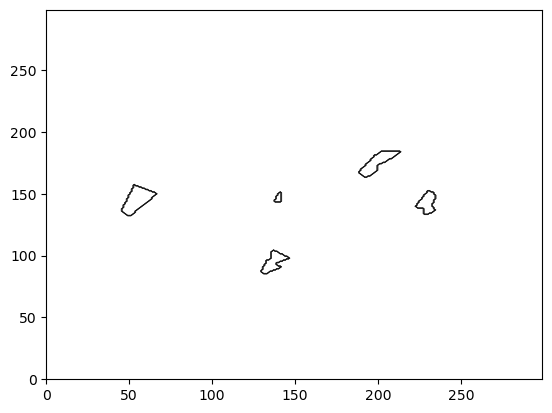

In [161]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.contour(warnings, colors = ('k'), linewidths = 0.25)

In [68]:
hazard = 'hail'
day_str = '20190430'
start_str = '2000'
end_str = '2100'
r = '39'
full_npy_fname = '%s/%s_reps1d_%s_v%s-%s_r%skm.npy' %(c.train_obs_full_npy_dir, hazard, day_str, start_str, end_str, str(r))
obs2000 = np.load(full_npy_fname)

In [71]:
hazard = 'hail'
day_str = '20190430'
start_str = '0100'
end_str = '0200'
r = '39'
full_npy_fname = '%s/%s_reps1d_%s_v%s-%s_r%skm.npy' %(c.train_obs_full_npy_dir, hazard, day_str, start_str, end_str, str(r))
obs0100 = np.load(full_npy_fname)

In [74]:
np.where(obs2000 == obs0100)[0]

array([    0,     1,     2, ..., 89997, 89998, 89999])

In [75]:
len(np.where(obs2000 == obs0100)[0])

90000

In [76]:
np.sum(obs2000)

6988.0

In [77]:
np.sum(obs0100)

6988.0

In [50]:
test = np.load('/work/ryan.martz/martz/warnings/warnings_grids_1d_sampled/all_haz_grid_20190725_init1900_valid1955-2025_1d_sampled.npy')
print(np.where(test == 0.5))
print(np.where(test == 1))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [79]:
infile = '/work/ryan.martz/wofs_phi_data/training_data/obs_and_warnings/sampled_1d_obs_and_warnings/length_60/wofs_lead_90/hail/sampled_hail_obs_and_warnings_20190714_0200_0224_v0330-0430_r7.5km.dat'
f = open ( infile , 'rb' )
arr = np.fromfile ( f , dtype = np.float32 , count = -1 )
f.close()

In [80]:
arr.shape

(9000,)